In [1]:
'''
odeint ->  Integrate a system of ordinary differential 
equations/ Solve a system of ordinary differential equations 
using lsoda from the FORTRAN library odepack.
'''

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# O modelo epidêmico SIR
## 1.1 Formulação:
Para desenvolver um modelo, primeiro precisamos discutir a terminologia. As doenças infecciosas são tipicamente classificadas como agudas ou crônicas. O termo aguda refere-se a infecções “rápidas”, onde a resposta imune relativamente rápida remove os patógenos após um curto período de tempo (dias ou semanas). Exemplos de infecções agudas incluem gripe, cinomose, raiva, catapora e rubéola. As infecções crônicas, por outro lado, duram muito mais tempo (meses ou anos) e exemplos incluem herpes e clamídia. Começamos o desenvolvimento de modelos focando em infecções agudas, assumindo que o patógeno causa a doença por um período de tempo seguido por imunidade (normalmente ao longo da vida). Este cenário é matematicamente melhor descrito pelos chamados modelos **SIR** (Dietz 1967). Este formalismo, que foi inicialmente estudado em profundidade por Kermack e McKendrick (1927), categoriza os hospedeiros dentro de uma população como **Suscetíveis** (se previamente não expostos ao patógeno), **Infectados** (se atualmente colonizados pelo patógeno) e **Recuperados** (se tiverem sucesso em eliminar a infecção).

Agora que sabemos quantas categorias existem e como essas categorias são definidas, a questão passa a ser como os indivíduos passam de uma para a outra. No caso mais simples (ignorando a demografia da população – nascimentos, mortes e migração), temos apenas as transições **S → I** e **I → R**. A segunda delas é mais fácil, então lidamos com ela primeiro. Os infectados podem passar para a classe recuperada apenas depois de terem combatido a infecção. Para infecções agudas, geralmente observa-se que o tempo gasto na classe infecciosa (o “período infeccioso”) se distribui em torno de algum valor médio, que muitas vezes pode ser estimado com precisão a partir de dados clínicos. De uma perspectiva de modelagem, isso se traduz na probabilidade de um indivíduo passar de **I** para **R** dependendo de quanto tempo ele está na classe **I**. No entanto, os modeladores muitas vezes fazem a suposição simplificadora de que a taxa de recuperação $\gamma$ (que é o inverso do período infeccioso) é constante; isso leva a equações muito mais diretas e períodos infecciosos exponencialmente distribuídos.

<center> 
<img src="https://github.com/gabrielxcosta/Simulation-of-epidemiological-models-in-temporal-mobility-networks/blob/main/Semana%201/SIR%20Model.png?raw=true"/>
 
<em>Diagramas de fluxo fornecem um método gráfico útil para ilustrar os principais pressupostos epidemiológicos subjacentes a um modelo.</em>
</center>

Essas descrições conceituais do modelo podem ser representadas por um diagrama de fluxo. O diagrama de fluxo para o modelo SIR usa setas pretas para mostrar o movimento entre as classes **S** e **I** e as classes **I** e **R**. O fato de que o nível da doença infecciosa influencia a taxa na qual um indivíduo suscetível se move para a classe infectada é mostrado pela seta cinza pontilhada. Em geral, a demografia será ignorada nesses diagramas para reduzir o número de setas e, portanto, melhorar sua clareza.

Os parágrafos anteriores fazem a derivação do termo de transmissão parecer relativamente simples. Infelizmente, a estrutura precisa do termo de transmissão é atormentada por controvérsias e nomenclaturas conflitantes. Para explicar algumas dessas questões, começamos definindo a *força de infecção*, $\lambda$, que é definida como a *taxa per capita* na qual indivíduos suscetíveis contraem a infecção. Assim, a taxa de produção de novos infectados é $\lambda X$, onde $X$ é o *número* de indivíduos da classe **S**. Essa força de infecção é intuitivamente proporcional ao número de indivíduos infectados. Para patógenos transmitidos diretamente, onde a transmissão requer contato entre infectados e suscetíveis, existem duas possibilidades gerais dependendo de como esperamos que a estrutura de contato mude com o tamanho da população: $\lambda = \frac{\beta Y}{N}$ e $\lambda = \beta Y$ (onde $Y$ é o número de indivíduos infecciosos, $N$ é o tamanho total da população e $\beta$ é o produto das taxas de contato e probabilidade de transmissão). A primeira destas formulações será referida como transmissão dependente de frequência (ou ação de massa) e a segunda como transmissão dependente de densidade (ou ação de pseudo-massa).

É importante distinguir entre esses dois pressupostos básicos em termos da estrutura subjacente de contatos dentro da população. A transmissão dependente de frequência reflete a situação em que o número de contatos é independente do tamanho da população. Pelo menos no que diz respeito às doenças transmitidas diretamente, isso está de acordo com nossa intuição natural sobre as populações humanas. Não esperamos que alguém que viva, por exemplo, em Londres (população de 7 milhões) ou Nova York (população de 8 milhões), transmita uma doença infecciosa 50 vezes mais do que alguém que vive em Cambridge, Reino Unido (população de 130.000) ou Cambridge, Massachusetts (população 100.000). O número de contatos próximos que provavelmente resultarão na transmissão da doença será determinado por restrições sociais, resultando em padrões semelhantes de transmissão em qualquer grande cidade. De fato, as estimativas das taxas de transmissão de sarampo na Inglaterra e no País de Gales não demonstram relação com o tamanho da população (Bjørnstad et al. 2002). Em contraste, a transmissão dependente da densidade assume que, à medida que o tamanho da população (ou mais precisamente, à medida que a densidade de indivíduos) aumenta, também aumenta a taxa de contato. A lógica é que, se mais indivíduos estiverem lotados em uma determinada área (e os indivíduos efetivamente se moverem aleatoriamente), a taxa de contato aumentará bastante. Como regra geral, a transmissão dependente da frequência (ação em massa) é considerada apropriada para patógenos transmitidos por vetores e aqueles com estrutura de contato heterogênea. A transmissão dependente da densidade (pseudo-ação em massa), no entanto, é geralmente considerada mais aplicável a doenças de plantas e animais, embora deva ser tomado cuidado na distinção entre número e densidade de organismos.

A distinção entre esses dois mecanismos de transmissão torna-se pronunciada quando o tamanho da população hospedeira varia, caso contrário o termo $\frac{1}{N}$ pode ser absorvido na parametrização de $\beta$ no termo de ação de massa. Como simplificação da nossa notação, é conveniente considerar $S = \frac{X}{N}$ e $I = \frac{Y}{N}$ a proporção da população que é suscetível ou infecciosa, respectivamente. Nesta nova notação, nossa suposição de ação em massa (dependente da frequência) torna-se $\beta S I$, que informa sobre a taxa na qual novos indivíduos infecciosos (como proporção do tamanho total da população) são infectados.

## 1.2 O Termo de Transmissão:

Aqui, derivamos dos primeiros princípios o termo de transmissão dependente da frequência (ação em massa), que é comumente usado em modelos epidêmicos. Ele assume uma mistura homogênea na população, o que significa que todos interagem com igual probabilidade com todos os outros; descarta possíveis heterogeneidades decorrentes de idade, espaço ou aspectos comportamentais. Considere um indivíduo suscetível com uma média de $k$ contatos por unidade de tempo. Destes, uma fração $I = \frac{Y}{N}$ são contatos com indivíduos infectados (onde $Y$ é o *número* de infectados e $N$ é o tamanho total da população). Assim, durante um pequeno intervalo de tempo (de $t$ a $t + \delta t$), o número de contatos com infectados é $\frac{kY}{N} × \delta t$. Se definirmos $c$ como a probabilidade de transmissão bem-sucedida da doença após um contato, então $1 − c$ é a probabilidade de que a transmissão não ocorra. Então, pela independência dos contatos, a probabilidade (indicada por $1 − \delta q$) de que um indivíduo suscetível escape da infecção após $\frac{kY}{N} × \delta t$ contatos é

$$1 - \delta q = (1 - c)^{\frac{kY}{N} \delta t}.$$

Assim, a probabilidade de o indivíduo ser infectado após qualquer um desses contatos é simplesmente $\delta q$. Agora definimos $\beta = −k log(1 − c)$ e substituímos na expressão por $1 − \delta q$, o que nos permite reescrever a probabilidade de transmissão em um pequeno intervalo de tempo $\delta t$ como

$$\frac{dq}{dt} = \frac{\beta Y}{N},$$

que é a taxa de transmissão por indivíduo suscetível. Na verdade, esta quantidade é frequentemente representada por $\lambda$ e referida como a “força da infecção” – mede a probabilidade per capita de adquirir a infecção (Anderson e May 1991). Então, por extensão, a taxa total de transmissão para toda a população suscetível é dada por

$$\frac{dX}{dt} = -\lambda X = - \frac{\beta XY}{N},$$

onde $X$ é definido como o *número* de suscetíveis na população. Se reescalarmos as variáveis (substituindo $S = \frac{X}{N}$ e $I = \frac{Y}{N}$ ) de modo que lidemos com frações (ou densidades), a equação acima se torna

$$\frac{dS}{dt} = -\beta I S$$

## 1.3 O modelo SIR sem demografia:

Para introduzir as equações do modelo, é mais fácil considerar uma “população fechada” sem dados demográficos (sem nascimentos, mortes ou migração). O cenário que temos em mente é uma grande população simples na qual um baixo nível de agente infeccioso é introduzido e onde a epidemia resultante ocorre com rapidez suficiente para que os processos demográficos não sejam influentes. Também assumimos uma mistura homogênea, onde as complexidades que afetam os padrões de contatos são descartadas, resultando em $\beta S I$ como o termo de transmissão. Dada a premissa de que as probabilidades epidemiológicas subjacentes são constantes, obtemos as seguintes equações SIR (1.1, 1.2 e 1.3 respectivamente):

$$\frac{dS}{dt} = -\beta S I,$$
$$\frac{dI}{dt} = \beta S I - \gamma I,$$
$$\frac{dR}{dt} =  \gamma I.$$

## 1.4 Exemplo do modelo em código:

O código Python a seguir integra essas equações para uma doença caracterizada por parâmetros $\beta = 0,2$, $1 / \gamma = 10$ dias em uma população de $N = 1000$ (talvez 'gripe em uma escola'). O modelo é iniciado com um único indivíduo infectado no dia 0: $I(0) = 1$. As curvas de $S(t)$, $I(t)$ e $R(t)$ são apresentadas ná célula abaixo:

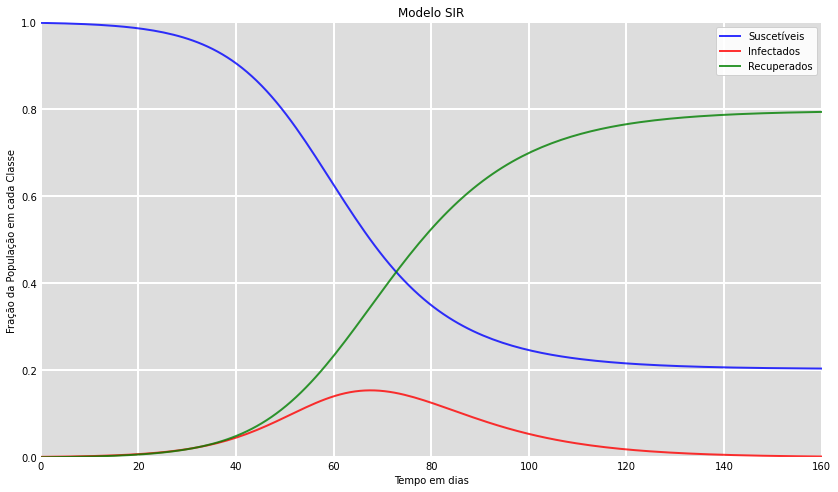

In [75]:
def modelSIR(y, t, N, beta, gamma):
    s, i, r = y
    dS_dt = - beta * s * i / N
    dI_dt = beta * s * i / N - gamma * i
    dR_dt = gamma * i
    return dS_dt, dI_dt, dR_dt

def stylizedGraphic(functionS, functionI, functionR, xAxis, title, yLim=None, xLim=None):
    y_i, y_f = yLim
    x_i, x_f = xLim
    fig = plt.figure(figsize=(14, 8), facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, functionS / 1000, 'b', alpha=0.8, lw=2, label='Suscetíveis')
    ax.plot(t, functionI / 1000, 'r', alpha=0.8, lw=2, label='Infectados')
    ax.plot(t, functionR / 1000, 'g', alpha=0.8, lw=2, label='Recuperados')
    ax.set_xlabel('Tempo em dias')
    ax.set_ylabel('Fração da População em cada Classe')
    ax.set_ylim(y_i, y_f)
    ax.set_xlim(x_i, x_f)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.9)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

# População total - N
N = 1000
# Número inicial de indivíduos infectados e recuperados - i0 e r0
i0, r0 = 1, 0
# Todos os outros, s0, são suscetíveis à infecção inicialmente
s0 = N - i0 - r0
# Taxa de contato, beta e taxa média de recuperação, gama (em 1 / dias)
beta, gamma = 0.2, 1. / 10 
# Uma linha de pontos de tempo (em dias)
t = np.linspace(0, 160, 160)

# Tupla de condições iniciais
y0 = s0, i0, r0
# Integrar as equações SIR na linha de tempo - t
ret = odeint(modelSIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

stylizedGraphic(S, I, R, t, 'Modelo SIR', [0, 1], [0, 160])